# Загрузка Pandas и очистка данных

In [1]:
import re
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

In [2]:
df = pd.read_csv('main_task.xls')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:

- **Restaurant_id** — _идентификационный номер ресторана/сети ресторанов;_
- **City** — _город, в котором находится ресторан;_
- **Cuisine Style** — _кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;_
- **Ranking** — _место, которое занимает данный ресторан среди всех ресторанов своего города;_
- **Rating** — _рейтинг ресторана по данным TripAdvisor <span style="color:green">(именно это значение должна будет предсказывать модель)</span>;_
- **Price Range** — _диапазон цен в ресторане;_
- **Number of Reviews** — _количество отзывов о ресторане;_
- **Reviews** — _данные о двух отзывах, которые отображаются на сайте ресторана;_
- **URL_TA** — _URL страницы ресторана на TripAdvisor;_
- **ID_TA** — _идентификатор ресторана в базе данных TripAdvisor._



- ### Данные целевой переменной Rating
---
> 1. Целевая переменная не содержит пропусков и выбросов  (dtype=int64).
> 2. Минимальное значение: 1. Максимальное значение: 5. Среднее: 3.99. Стандартное отклонение: 0.67.

In [3]:
df['Rating'].value_counts(dropna=False)

4.0    13692
4.5    10929
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: Rating, dtype: int64

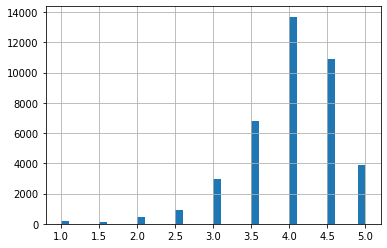

In [4]:
df.Rating.hist(bins=40) 
plt.show()

- ### Идентификационный номер ресторана/сети ресторанов
---
> 1. Рестораны крупных сетей имеют общий рейтинг выше среднего
> 2. Отдельным признаком выделяем средний рейтинг сети ресторанов (Average_Rating_Restaurant_Chain)

In [5]:
id_counts = df['Restaurant_id'].value_counts()\
                                .rename_axis('Restaurant_id')\
                                    .reset_index(name='Restaurant_Counts')
id_counts['Mean_Rating'] = id_counts['Restaurant_id']\
                                .apply(lambda x : df['Rating'][df['Restaurant_id'] == x].mean())

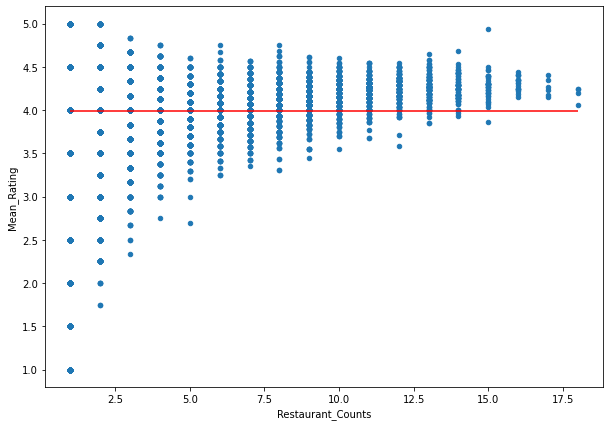

In [6]:
# посмотрим на зависимость количества ресторанов одной сети и среднего рейтинга этой сети
plt.rcParams['figure.figsize'] = (10,7)
pt = id_counts.plot( 
    x='Restaurant_Counts', 
    y='Mean_Rating', 
    kind='scatter',
)

# добавим на график среднее значение рейтинга
pt.hlines(
    y=df['Rating'].mean(), 
    xmin=id_counts['Restaurant_Counts'].min(), 
    xmax=id_counts['Restaurant_Counts'].max(), 
    color='red', 
    label='mean',
) 
plt.show()

# чем больше сеть ресторанов, тем выше их средний рейтинг

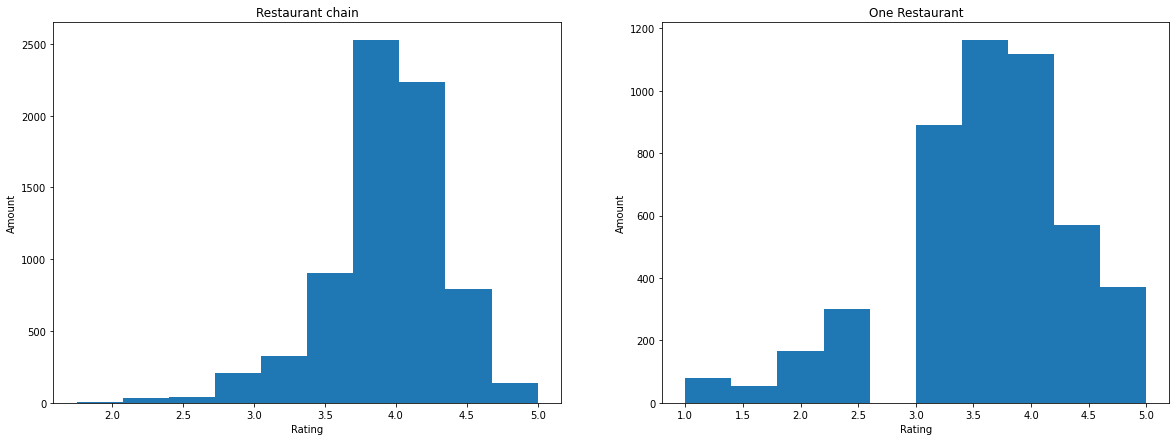

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

# распределение среднего значения рейтинга для сети ресторанов (> 1 ресторана в сети)
restaurant_chain = id_counts['Mean_Rating'][id_counts['Restaurant_Counts'] > 1]
ax[0].hist(restaurant_chain)
ax[0].set_title('Restaurant chain')
ax[0].set_xlabel("Rating")
ax[0].set_ylabel("Amount")

# распределение значения рейтинга для ресторанов "одиночек" (= 1 ресторан)
one_restaurant = id_counts['Mean_Rating'][id_counts['Restaurant_Counts'] == 1]
ax[1].hist(one_restaurant)
ax[1].set_title('One Restaurant')
ax[1].set_xlabel("Rating")
ax[1].set_ylabel("Amount")
plt.show()

- ### Города, в которых находятся рестораны
---
> 1. В городах London, Paris, Madrid, Barcelona, Berlin и Milan находятся больше половины ресторанов представленных в датасете
> 2. Кодируем категориальные признаки, используя подход One-Hot Encoding 

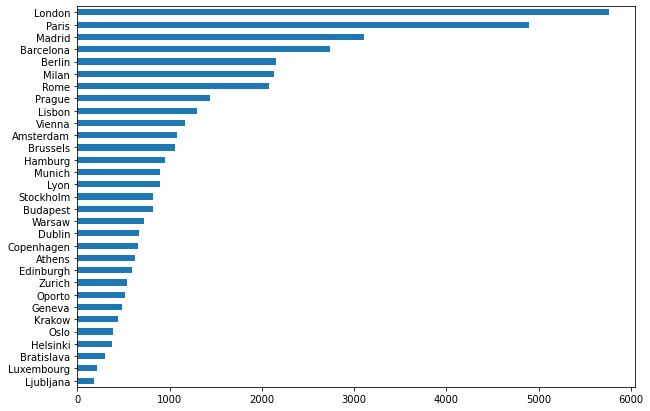

In [8]:
# посмотрим на города представленные в датасете
plt.rcParams['figure.figsize'] = (10,7)
df['City'].value_counts(ascending=True).plot(kind='barh')
plt.show()

- ### Кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане
---
> 1. В датафрейме присутствуют 125 различных стилей кухонь
> 2. Чаще всего встречается Vegetarian Friendly
> 3. В среднем в одном ресторане представлено 2.6 стилей кухонь
> 4. Создаю признак "Количество кухонь в одном ресторане" (Amount_Cuisine_Style) 
> 5. Создаю признак "Среднее количество кухонь каждой сети ресторанов" (Average_Number_of_Kitchens_Restaurant_Chain)

In [9]:
def format_str_values_to_list(text):
    def replaces(text):
        rep = {"[": "", "]": "", "'": ""}
        rep = dict((re.escape(k), v) for k, v in rep.items())
        pattern = re.compile("|".join(rep.keys()))
        return pattern.sub(lambda m: rep[re.escape(m.group(0))], str(text))

    if not pd.isna(text):
        if text == '[[], []]': # для колонки Reviews
            return None
        new_str = replaces(text)
        return new_str.split(', ')
    
df['Cuisine Style'] = df['Cuisine Style'].apply(format_str_values_to_list)

In [10]:
def get_unique_values_cuisine_style(series):
        cuisine = set()
        for list_ in series:
            if list_ != None:
                for elem in list_:
                    cuisine.add(elem)
        return list(cuisine)
    
print('Всего представлено стилей кухонь:', len(get_unique_values_cuisine_style(df['Cuisine Style'])))

Всего представлено стилей кухонь: 125


In [11]:
def get_most_popular_cuisine(series):
        cuisine_dict = {}
        for list_ in series:
            if list_ != None:
                for elem in list_:
                    if elem in cuisine_dict:
                        cuisine_dict[elem] += 1
                    else:
                        cuisine_dict[elem] = 1
        return max(cuisine_dict, key=cuisine_dict.get)
    
print('Самая популярная кухня:', get_most_popular_cuisine(df['Cuisine Style']))

Самая популярная кухня: Vegetarian Friendly


- ### Место, которое занимает данный ресторан среди всех ресторанов своего города
---
> 1. Есть рестораны с максимальным рейтингом занимающие одни из последних мест среди ресторанов своих городов. Поработаем над очисткой данных от выбросов

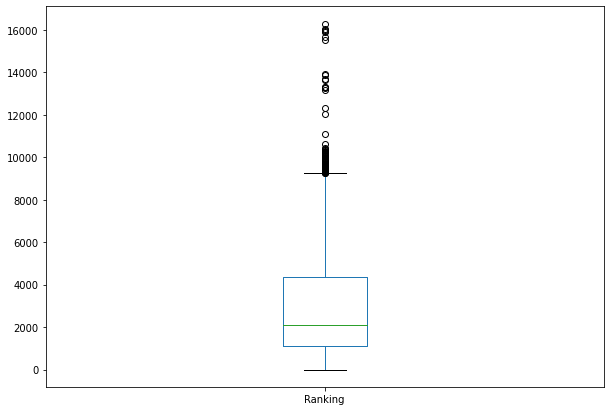

In [12]:
# места ресторанов с самым высоким рейтингом
df['Ranking'][df['Rating'] == 5].plot.box()
plt.show()

- ### Диапазон цен в ресторане
---
> 1. Диапазон цен представленный в датасете можно заменить последовательными числами
> 2. У ресторанов с высоким рейтингом чаще встречается средний ценовой диапазон
> 3. Почти половина данных отсутствует
> 4. Добавим новый признак - максимальная ценовая категория в сети ресторанов (Max_Price_Range_Restaurant_Chain)
> 5.Добавим новый признак - минимальная ценовая категория в сети ресторанов (Min_Price_Range_Restaurant_Chain)
> 6. Новым признаком будет среднее значение ценовой категории по городам (Average_Price_Range_by_City)

In [13]:
df['Price Range'].value_counts(dropna=False)

$$ - $$$    18412
NaN         13886
$            6279
$$$$         1423
Name: Price Range, dtype: int64

In [14]:
# посмотрим на ценовой диапазон рестранов с высоким рейтингом
df['Price Range'][df['Rating'] == 5].value_counts(dropna=False)

NaN         2222
$$ - $$$     866
$            688
$$$$         103
Name: Price Range, dtype: int64

In [15]:
# посмотрим на ценовой диапазон рестранов с низким рейтингом
df['Price Range'][df['Rating'] == 1].value_counts(dropna=False)

NaN         165
$$ - $$$     18
$            14
$$$$          4
Name: Price Range, dtype: int64

- ### Количество отзывов о ресторане
---
> 1. В пределах 100 отзывов больше половины ресторанов. Около 1% данных находится за пределами 1200 отзывов
> 2. Медианное значение количества отзывов в городе (Median_Number_of_Reviews_by_City)

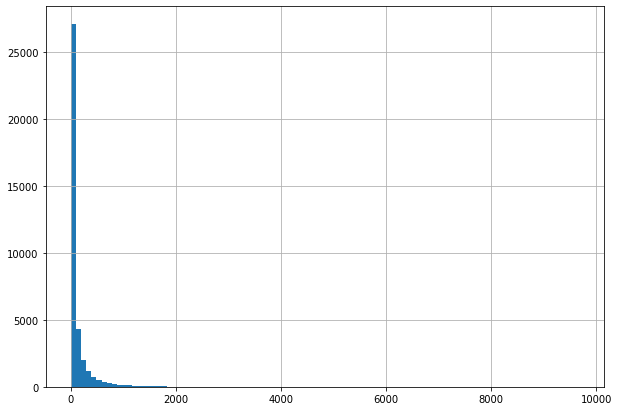

In [16]:
# распределение количества отзывов
df['Number of Reviews'].hist(bins=100)
plt.show()

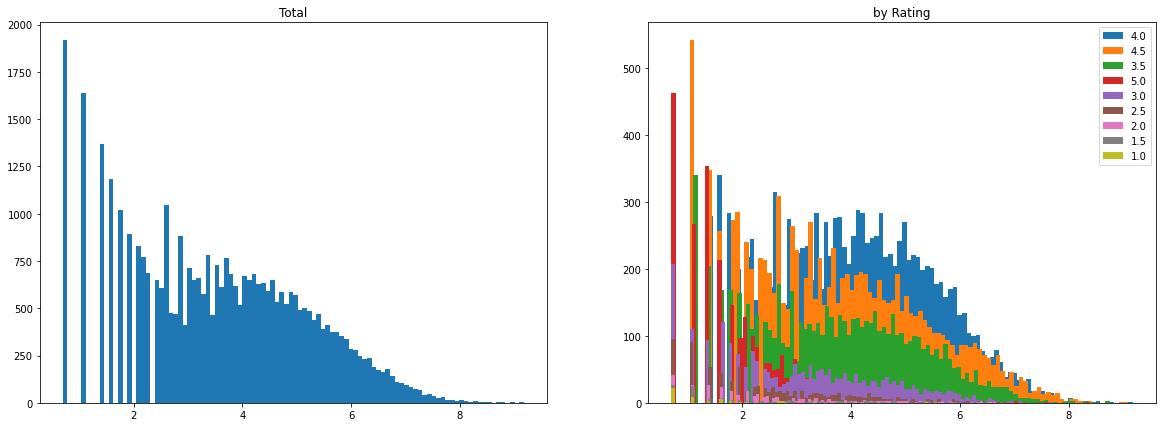

In [17]:
# применим логорифмирование к переменной Number of Reviews
log_number_of_reviews = np.log(df['Number of Reviews'][~pd.isna(df['Number of Reviews'])])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

# взглянем на распределение всех значений прологарифмированной переменной
ax[0].set_title('Total')
ax[0].hist(log_number_of_reviews, bins=100)

# смущает вид прологарифмированного распределения
# изобразим распределение количества отзывов по рейтингу
ax[1].set_title('by Rating')
data_without_nan = df['Rating'][~pd.isna(df['Number of Reviews'])] # исключаем пропуски в Number of Reviews
for rating in data_without_nan.value_counts().index:
    if rating != 0: # т.к. 0 только в sample
        ax[1].hist(log_number_of_reviews.loc[data_without_nan[data_without_nan == rating].index], bins=100, label=str(rating))
        ax[1].legend()
plt.show()

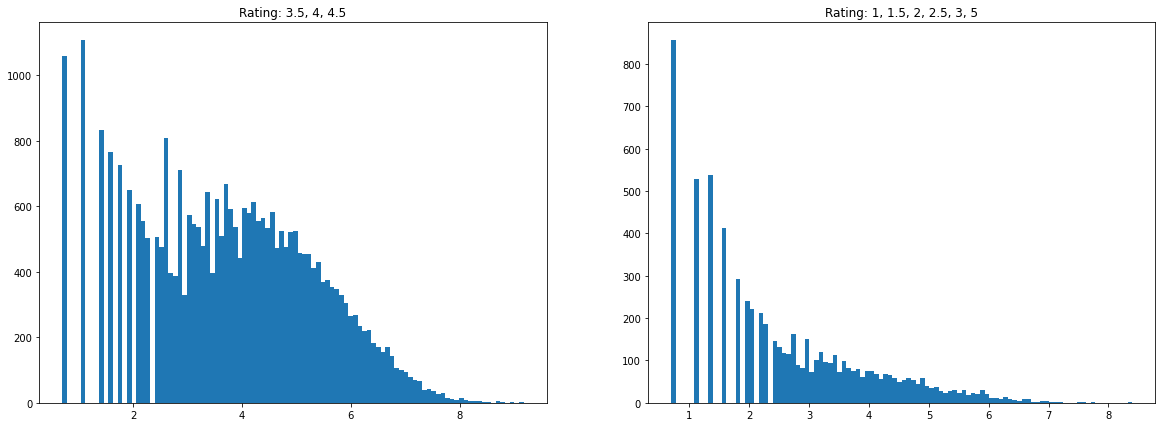

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

# распределение признака Number of Reviews с рейтингами 3.5, 4 и 4.5
ax[0].set_title('Rating: 3.5, 4, 4.5')
ax[0].hist(log_number_of_reviews.loc[data_without_nan[data_without_nan.isin([3.5, 4, 4.5])].index], bins=100)
                            
# распределение признака Number of Reviews с рейтингами 1, 1.5, 2, 2.5, 3 и 5
ax[1].set_title('Rating: 1, 1.5, 2, 2.5, 3, 5')
ax[1].hist(log_number_of_reviews.loc[data_without_nan[data_without_nan.isin([1, 1.5, 2, 2.5, 3, 5])].index], bins=100)
plt.show()

# в реалистичности количества отзывов ресторанов с рейтингом от 3.5 до 4.5 можно усомниться

- ### Данные о отзывах, которые отображаются на сайте ресторана
---
> 1. Cчитаю выбросами данные о количестве дней между публикациями отзывов превышающие среднее значение пременной более чем на 3 стандартных отклонения
> 2. Отдельным признаком выделяем суммарное количество больших букв в 2х отзывах (Caps_Reviews)
> 3. Отдельным признаком выделяем количество дней между публикациями отзывов (Span_Reviews)

In [19]:
df['Reviews'] = df['Reviews'].apply(format_str_values_to_list)

def get_date_from_reviews(reviews_list, arg):
    reviews_date_list = []
    if reviews_list != None:
        for value in reviews_list[-2:]:
            try:
                reviews_date_list.append(datetime.strptime(value, '%m/%d/%Y'))
            except:
                continue
        if arg == 1:
            return reviews_date_list[0]
        elif arg == 2:
            try:
                return reviews_date_list[1]
            except IndexError:
                return None

df['First_Reviews_Date'] = df['Reviews'].apply(get_date_from_reviews, args=(1,))
df['Second_Reviews_Date'] = df['Reviews'].apply(get_date_from_reviews, args=(2,))

def get_days_between_reviews(span_date):
    if not pd.isna(span_date):
        days = span_date.days
        if days < 0:
            return int(-days)
        else:
            return int(days)

# время в сутках между публикациями отзывов
df['Span_Reviews'] = df['First_Reviews_Date'] - df['Second_Reviews_Date']
df['Span_Reviews'] = df['Span_Reviews'].apply(get_days_between_reviews)

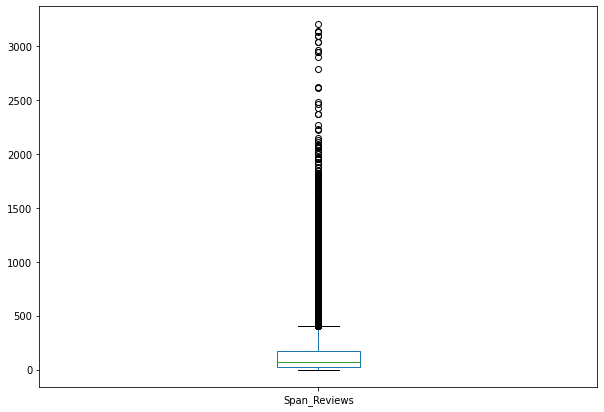

In [20]:
# максимальное количество дней 3207 между отзывами
# на общем фоне 
df['Span_Reviews'].plot.box()
plt.show()

- ### URL страницы ресторана на TripAdvisor
---
> 1. Ссылка состоит из 2х частей: Название ресторана - Место нахождения
> 2. Отдельным признаком выносим количество символов в названии ресторана (Number_of_Characters_in_the_Name)

In [21]:
# из любой ссылки можно выделить Название - Место
df['URL_TA'].sample().iloc[0].replace('.html', '').split('-')[-2:]

['Da_Jia_Le', 'Berlin']

- ### Идентификатор ресторана в базе данных TripAdvisor
---
> 1. Есть повторяющиеся идентификаторы ресторанов в базе данных. Отличие лишь в колонке Ranking. (повторное добавление ресторана в базу данных)

In [22]:
s = df['ID_TA'].value_counts(dropna=False)
df[df['ID_TA'] == s[s==2].sample(1).index.values[0]]

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,First_Reviews_Date,Second_Reviews_Date,Span_Reviews
8421,id_3811,Madrid,[Spanish],3813.0,4.0,$,23.0,"[Happened to drop in, Right for a quick bite, ...",/Restaurant_Review-g187514-d2477531-Reviews-Ha...,d2477531,2016-11-30,2015-06-20,529.0
24545,id_3805,Madrid,[Spanish],3807.0,4.0,$,23.0,"[Happened to drop in, Right for a quick bite, ...",/Restaurant_Review-g187514-d2477531-Reviews-Ha...,d2477531,2016-11-30,2015-06-20,529.0


<div style="text-align: center">
    <img src="https://znanieinfo.ru/wp-content/cache/thumb/44/279634fc1717644_810x260.jpg" />
</div>

In [23]:
# Исходя из вышеизложенных наблюдений очищаем и подготавливаем данные
from handling import ConfigWrapper
df_obj = ConfigWrapper(pd.read_csv('main_task.xls'))

# Pss.. У меня огромные вопросы к производительности написанного мною кода. Я уверен, что его можно оптимизировать =) но ...
# придется подождать примерно минут 5 (i5 3Ггц 8 OЗУ)...

# Анекдот
# !Осторожно! Смешно только для беларусов...

# Один беларус - Беларус
# Два беларуса - Партизанский отряд
# Три беларуса - Партизанский отряд и Предатель

10% ...
20% ...
30% ...
40% ...
50% ...
60%...
70% ...
80% ...
90% ...


- ### Корреляция признаков
---

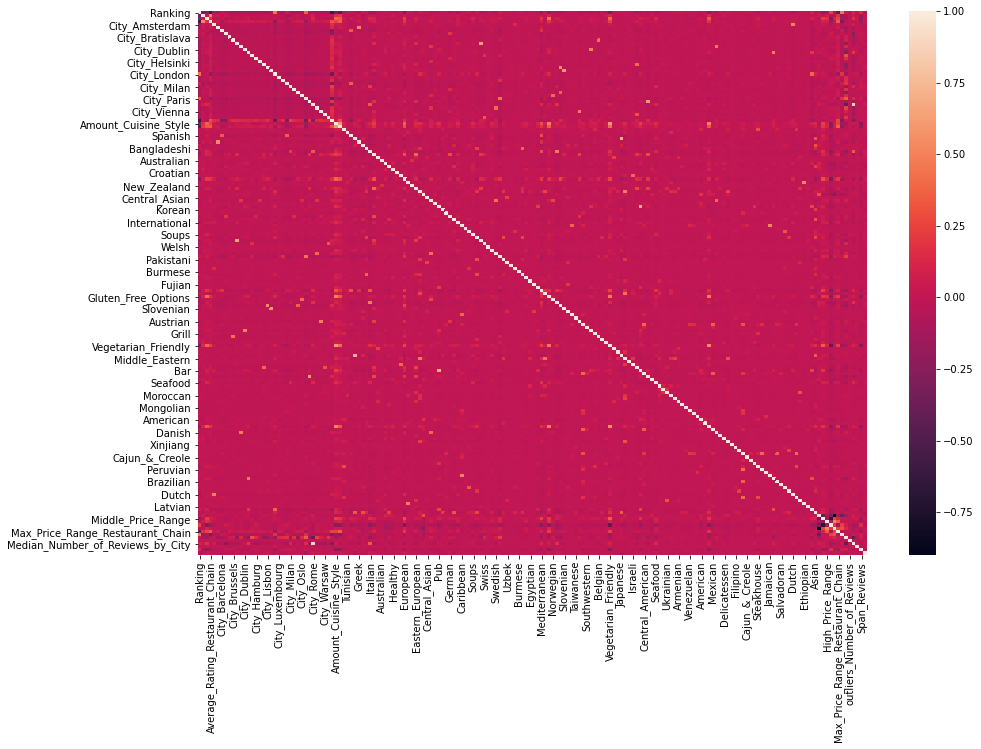

In [24]:
plt.rcParams['figure.figsize'] = (15,10)
corr = df_obj.final_data.corr()
sns.heatmap(corr)
plt.show()

In [25]:
# не пропускаем признаки с высокой корреляцией
for column in corr.columns:
    for row in corr[column].index:
        if corr[column][row] > 0.85 or corr[column][row] < -0.85:
            if row != column:
                print('row:', row)
                print('column:', column)

row: Median_Number_of_Reviews_by_City
column: City_Rome
row: Price Range
column: Low_Price_Range
row: Low_Price_Range
column: Price Range
row: City_Rome
column: Median_Number_of_Reviews_by_City


In [26]:
# наблюдаем высокую корреляцию признаков City_Rome (место нахождения ресторана - Рим) и Median_Number_of_Reviews_by_City (медианное значение количества отзывов по горорам) 
# сложно предположить взаимосвязь этих признаков, но для чистоты эксперимента было принято решение удалить менее важный признак для модели (City_Rome)
df_obj.final_data.drop(columns='City_Rome', inplace=True)
# так же поступаем и с другой парой коррелирующий признаков Price Range и Low_Price_Range
df_obj.final_data.drop(columns='Low_Price_Range', inplace=True)

---

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [27]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df_obj.final_data.drop(columns='Rating')
y = df_obj.final_data['Rating']

In [28]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [29]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [30]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [31]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [32]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.16986543271635818


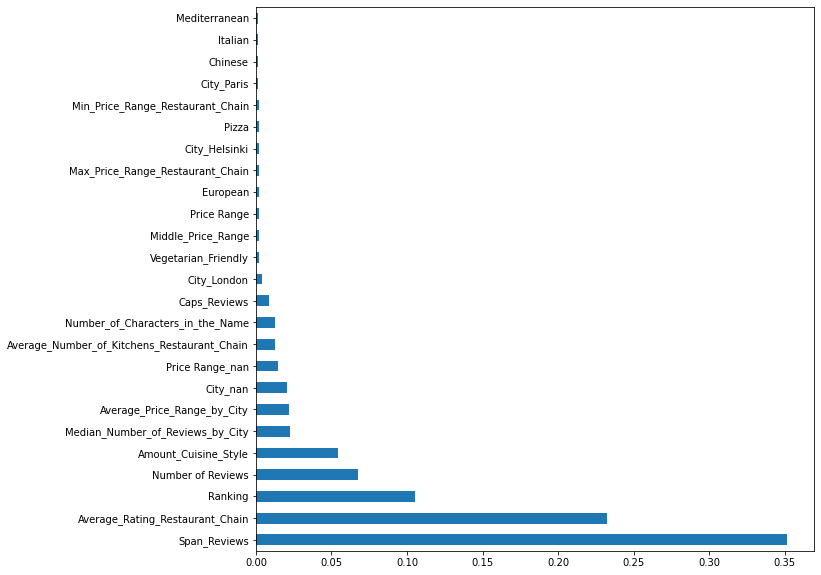

In [33]:
# выведем самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()